In [3]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from torch.utils.data import DataLoader, ConcatDataset,Dataset
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn as nn
import torchvision.transforms as T
import random
from torchinfo import summary
from tqdm import tqdm

In [4]:
# Path to your dataset folder
path = "../new_data"

In [5]:
num_epochs = 25  # Number of epochs
learning_rate = 0.00001  # Learning rate
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cuda'

In [7]:
def strokeToImage(strokes):

    def rotate(x, y, angle):
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        x_rot = c * x - s * y
        y_rot = s * x + c * y
        return x_rot, y_rot
    
    x, y = strokes[0][0], strokes[0][1]

    # Create a figure and canvas to render the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    canvas = FigureCanvas(fig)
    
    for stroke in strokes:
        
        dx, dy, pen_up = stroke[0],stroke[1],stroke[2]
        
        
        new_x, new_y = x+dx, y+dy  

        if pen_up == 0:
            ax.plot([x,new_x], [y,new_y], color='black')

        x, y = new_x, new_y

    # Set limits for the plot
    ax.set_xlim(-800, 800)
    ax.set_ylim(-800, 800)
    
    # Remove axis ticks and labels for a clean image
    ax.axis('off')

    # Render the plot to the canvas
    canvas.draw()

    # Convert the canvas to a NumPy array
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    
    # Get the width and height from the figure
    width, height = fig.get_size_inches() * fig.get_dpi()

    # Reshape the buffer to the correct dimensions (height, width, 3) for an RGB image
    image = image.reshape(int(height), int(width), 3)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # bw_img will be of shape (32, 32)

    
    img_resized = cv2.resize(img, (250, 250))

    # Optionally rotate the image if needed
    img_resized = np.rot90(img_resized, k=2)

    plt.close(fig)

    return img_resized



def strokeProcess(strokes, limit):
    # Create the placeholder array
    place_holder = np.array([[0, 0, 1]])

    # Add initial placeholder stroke
    strokes = np.vstack([place_holder, strokes])

    # Get the length of the strokes array
    leng = len(strokes)

    if leng < limit:
        # If there are fewer strokes than the limit, pad with placeholders
        padding = np.tile(place_holder, (limit - leng, 1))
        strokes = np.vstack([strokes, padding])
    else:
        # If there are more strokes than the limit, truncate to the limit
        strokes = strokes[:limit]

    # Append a final placeholder stroke
    strokes = np.vstack([strokes, place_holder])
    
    return strokes

In [8]:
# dataloader
class customDataset(Dataset):
    def __init__(self,strokes_path,split,transform=None):
        self.strokes_path = strokes_path
        self.split = split
        self.transform = transform
        self.data = np.load(self.strokes_path,encoding='latin1',allow_pickle=True)[split]

        
        


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        strokes = self.data[index]
        main_strokes = strokes[:3, :]
        last_strokes = strokes

        img = strokeToImage(main_strokes)  # Image from half-drawn strokes
        main_strokes = strokeProcess(main_strokes, 100)
        last_strokes = strokeProcess(last_strokes,100)

        ref_img = strokeToImage(strokes)  # You may change this to select a different reference image

        if self.transform:
            img = self.transform(img)
            ref_img = self.transform(ref_img)

        resize_transform = T.Resize((250, 250))
        
        img = resize_transform(torch.tensor(img.copy(), dtype=torch.float32).unsqueeze(0))  # Add channel dimension
        ref_img = resize_transform(torch.tensor(ref_img.copy(), dtype=torch.float32).unsqueeze(0))  # Reference image tensor
        later_strokes = torch.tensor(last_strokes, dtype=torch.float32)
        main_strokes = torch.tensor(main_strokes, dtype=torch.float32)
        

        return img, ref_img, main_strokes,later_strokes




# Initialize an empty list to store the datasets
train_datasets = []
test_datasets = []
val_datasets = []

# Loop through the files in the directory
for folder in os.listdir(path):
    # Check the file extension and name format
    print(folder)
    
    if folder.split('.')[1] != "full":
        folder_path = os.path.join(path, folder)

        try:
            # Assuming customDataset is your function or class that loads the dataset
            train_data = customDataset(folder_path, "train")
            test_data = customDataset(folder_path, "test")
            val_data = customDataset(folder_path, "valid")

            # Append the dataset to the list
            train_datasets.append(train_data)
            test_datasets.append(test_data)
            val_datasets.append(val_data)
            

        except KeyError as e:
            # Handle the KeyError in case 'train' is not in the npz file
            print(f"KeyError: {e} in file {folder_path}")
            continue  # Skip to the next file if an error occurs

# Concatenate all the datasets
train_data = ConcatDataset(train_datasets)
test_data = ConcatDataset(test_datasets)
val_data = ConcatDataset(val_datasets)


train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=True)
val_loader = DataLoader(val_data, batch_size=2, shuffle=True)

airplane.npz


In [9]:
from torch.utils.data import DataLoader

# Assuming train_loader is your DataLoader instance
num_batches = len(train_loader.dataset) // train_loader.batch_size
if len(train_loader.dataset) % train_loader.batch_size != 0:
    num_batches += 1  # account for the last partial batch

print("Number of batches:", num_batches)


Number of batches: 35000


In [15]:
import torch
import torch.nn as nn

class Conv2dModel(nn.Module):
    def __init__(self, cnn_out, input_channels=1, input_size=(1, 250, 250)):
        super(Conv2dModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x125x125
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x62x62
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x31x31
            nn.Flatten()
        )
        
        # Compute the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self.cnn(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)
            print(f"Flattened size: {flattened_size}")  # Debugging purpose
        
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, cnn_out),
            nn.ReLU()
        )
    
    def forward(self, img):
        x = self.cnn(img)
        x = self.fc(x)
        return x


class Encoder(nn.Module):
    def __init__(self, cnn_out_dim, output_dim):
        super(Encoder, self).__init__()
        
        self.half_cnn = Conv2dModel(cnn_out_dim)
        self.full_cnn = Conv2dModel(cnn_out_dim)
        
        self.fc_xy = nn.Sequential(
            nn.Linear(cnn_out_dim * 2, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, 2)  # Output for next stroke (x, y)
        )
        
        # Define a separate layer for z with a sigmoid activation
        self.fc_z = nn.Sequential(
            nn.Linear(cnn_out_dim * 2, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, 1),
            nn.Sigmoid()  # Ensure z is between 0 and 1
        )

    def forward(self, half_img, full_img):
        # Get encodings for half and full images
        half_img_encoding = self.half_cnn(half_img)
        full_img_encoding = self.full_cnn(full_img)
        
        # Concatenate encodings from both images
        combined_encoding = torch.cat((half_img_encoding, full_img_encoding), dim=1)
        
        # Predict next stroke
        xy_output = self.fc_xy(combined_encoding)  # Shape: [batch_size, 2]
        
        # Predict z (binary output between 0 and 1)
        z_output = self.fc_z(combined_encoding)  # Shape: [batch_size, 1]
        z_output_binary = (z_output > 0.5).float()  # Threshold to make z binary (0 or 1)
        
        # Concatenate xy and z outputs to form the final output
        output = torch.cat((xy_output, z_output_binary), dim=1)  # Shape: [batch_size, 3]
        
        return output

In [16]:
len(next(iter(train_loader)))

/tmp/ipykernel_16003/548956240.py:39: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


4

In [17]:
# temp = next(iter(train_loader))

# print(temp[0].shape)
# print(temp[1].shape)
# print(temp[2][0])
# print("last : ",temp[3][1])

In [18]:
model = Encoder(cnn_out_dim=32, output_dim=64).to(device)

train_losses = []
val_losses = []
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
alpha = 0.7  
beta = 0.3  
criterion = nn.MSELoss()
# model.load_state_dict(torch.load('../saved_models/best_model.pth'))
# model.eval()

Flattened size: 123008
Flattened size: 123008


/tmp/ipykernel_16003/548956240.py:39: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
Processing Strokes for Batch 0:   0%|                                     | 0/2 [00:00<?, ?sample/s]

Processing Strokes for Batch 0:   0%|                                     | 0/2 [00:04<?, ?sample/s]


KeyboardInterrupt: 

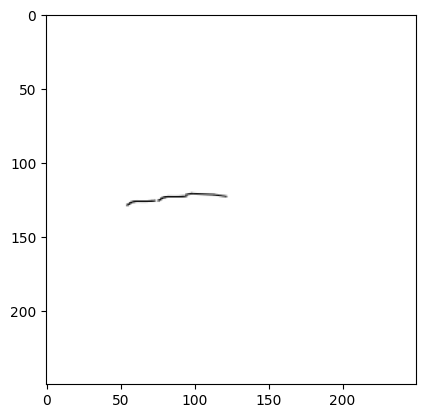

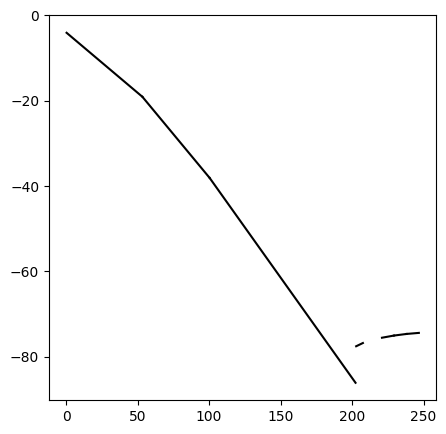

In [19]:
from tqdm import tqdm

best_val_loss = float('inf')  # Initialize the best validation loss as infinity

# Open a log file to save training and validation losses
log_file_path = 'training_logs.txt'
with open(log_file_path, 'w') as log_file:

    # Your training loop
    for epoch in range(1):
        model.train()  # Set the model to training mode
        epoch_loss = 0

        for t, batch in enumerate(train_loader):
            ref_img, half_img, strokes, last_strokes = batch  
            ref_img = ref_img.to(device)
            half_img = half_img.to(device)
            half_strokes = strokes.to(device)
            strokes = last_strokes.to(device)

            batch_loss = 0.0
            for sample in tqdm(range(strokes.shape[0]), desc=f"Processing Strokes for Batch {t}", ncols=100, unit="sample"):
                for i in range(strokes.size(1)):  # Loop over each stroke in the sequence
                    actual_stroke = strokes[:, i, :]  # Shape: [batch_size, 3]
                    predicted_stroke = model(half_img, ref_img).to(device)  # Shape: [batch_size, 3]

                    batch_size, sequence_length, _ = half_strokes.shape
                    target_row = torch.tensor([0., 0., 1.]).to(device)

                    for batch_idx in range(batch_size):
                        for stroke_idx in range(sequence_length):
                            if torch.equal(half_strokes[batch_idx, stroke_idx], target_row):
                                half_strokes[batch_idx, stroke_idx] = predicted_stroke[batch_idx]
                                break

                    loss = criterion(predicted_stroke, actual_stroke)
                    batch_loss += loss.item()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    predicted_stroke = predicted_stroke.unsqueeze(1)
                    half_strokes = torch.cat((half_strokes, predicted_stroke), dim=1)

                    images = []
                    for seq in half_strokes:
                        img = strokeToImage(seq.cpu().detach().numpy())  # Convert to NumPy array
                        images.append(img)

                    new_half_img_list = []
                    for img in images:
                        tensor_img = torch.from_numpy(img.copy()).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 250, 250]
                        new_half_img_list.append(tensor_img)

                    new_half_img = torch.cat(new_half_img_list, dim=0).float().to(device)  # Shape: [batch_size, 1, 250, 250]
                    half_img = new_half_img.cpu().detach()
                    plt.imshow(half_img[0][0], cmap='gray')
                    half_img = new_half_img

                epoch_loss += batch_loss / strokes.size(1)  # Average over sequence length

        epoch_loss /= len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
        log_file.write(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}\n')

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for t, batch in enumerate(tqdm(val_loader, desc=f"Validation Progress", ncols=100, unit="batch")):
                ref_img, half_img, strokes, last_strokes = batch
                ref_img = ref_img.to(device)
                half_img = half_img.to(device)
                half_strokes = strokes.to(device)
                strokes = last_strokes.to(device)

                batch_val_loss = 0.0
                for i in range(strokes.size(1)):  # Loop over each stroke in the sequence
                    actual_stroke = strokes[:, i, :]  # Shape: [batch_size, 3]
                    predicted_stroke = model(half_img, ref_img)  # Shape: [batch_size, 3]

                    val_loss_step = criterion(predicted_stroke, actual_stroke)
                    batch_val_loss += val_loss_step.item()

                    predicted_stroke = predicted_stroke.unsqueeze(1)
                    half_strokes = torch.cat((half_strokes, predicted_stroke), dim=1)

                    images = [strokeToImage(seq.cpu().detach().numpy()) for seq in half_strokes]
                    new_half_img_list = [torch.from_numpy(img.copy()).unsqueeze(0).unsqueeze(0) for img in images]
                    new_half_img = torch.cat(new_half_img_list, dim=0).float().to(device)
                    check = new_half_img.cpu().detach()
                    plt.imshow(check, cmap='gray')
                    half_img = new_half_img

                val_loss += batch_val_loss / strokes.size(1)

        val_loss /= len(val_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
        log_file.write(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}\n')

        # Save the best model if current val_loss is the lowest
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '../saved_models/best_model.pth')
            print(f'Best model saved with validation loss: {best_val_loss:.4f}')
            log_file.write(f'Best model saved with validation loss: {best_val_loss:.4f}\n')

        # Save the last model at the end of training
        if epoch == num_epochs - 1:
            torch.save(model.state_dict(), '../saved_models/last_model.pth')
            print("Last model saved.")
            log_file.write("Last model saved.\n")

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
